# **Objective**: 
##### **The goal of this task is to classify cybersecurity threats based on a given dataset using Machine Learning. You are required to preprocess the data, train an ML model, and evaluate its performance.**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb

### **Load the data**

In [76]:
data = pd.read_csv('TestbedMonJun14Flows.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171380 entries, 0 to 171379
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   generated                       171380 non-null  object 
 1   appName                         171380 non-null  object 
 2   totalSourceBytes                171380 non-null  int64  
 3   totalDestinationBytes           171380 non-null  int64  
 4   totalDestinationPackets         171380 non-null  int64  
 5   totalSourcePackets              171380 non-null  int64  
 6   sourcePayloadAsBase64           84579 non-null   object 
 7   sourcePayloadAsUTF              0 non-null       float64
 8   destinationPayloadAsBase64      74634 non-null   object 
 9   destinationPayloadAsUTF         74616 non-null   object 
 10  direction                       171380 non-null  object 
 11  sourceTCPFlagsDescription       122074 non-null  object 
 12  destinationTCPFl

#### **Drop the rows where Label column contains NaN**

In [5]:
data = data.dropna(subset=['Label'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171380 entries, 0 to 171379
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   generated                       171380 non-null  object 
 1   appName                         171380 non-null  object 
 2   totalSourceBytes                171380 non-null  int64  
 3   totalDestinationBytes           171380 non-null  int64  
 4   totalDestinationPackets         171380 non-null  int64  
 5   totalSourcePackets              171380 non-null  int64  
 6   sourcePayloadAsBase64           84579 non-null   object 
 7   sourcePayloadAsUTF              0 non-null       float64
 8   destinationPayloadAsBase64      74634 non-null   object 
 9   destinationPayloadAsUTF         74616 non-null   object 
 10  direction                       171380 non-null  object 
 11  sourceTCPFlagsDescription       122074 non-null  object 
 12  destinationTCPFl

In [30]:
def cramers_v(feature, target):
    contingency = pd.crosstab(feature, target)
    chi2 = chi2_contingency(contingency)[0]
    n = contingency.sum().sum()
    phi2 = chi2/n
    r,k = contingency.shape
    return np.sqrt(phi2 / min((k-1),(r-1)))

# Sample implementation for payload presence
data['has_source_payload'] = data['sourcePayloadAsBase64'].notnull()
print(f"Payload Presence Correlation: {cramers_v(data['has_source_payload'], data['Label']):.3f}")

# TCP flag analysis
tcp_flags = data['sourceTCPFlagsDescription'].fillna('NON_TCP')
print(f"TCP Flag Correlation: {cramers_v(tcp_flags, data['Label']):.3f}")


Payload Presence Correlation: 0.142
TCP Flag Correlation: 0.863


#### **Remove redundant columns and feature engineering**
        1.  for missing values we used the presence flag to indicate the presence of payload
        2.  calculate the Shannon entropy of the payload data (measure of randomness)
        3.  calculate the length of the payload data

In [32]:
data.drop(columns=['sourcePayloadAsUTF','destinationPayloadAsUTF'], inplace=True)

# Payload feature engineering
for direction in ['source', 'destination']:
    # Presence flag
    data[f'{direction}_payload_present'] = data[f'{direction}PayloadAsBase64'].notnull().astype(int)
    
    # Entropy calculation
    data[f'{direction}_payload_entropy'] = data[f'{direction}PayloadAsBase64'].apply(
        lambda x: -sum((count/len(x))*np.log2(count/len(x)) 
                      for count in pd.Series(list(x)).value_counts()) 
                      if pd.notnull(x) else 0)
    
    # Length calculation
    data[f'{direction}_payload_length'] = data[f'{direction}PayloadAsBase64'].str.len().fillna(0)

# TCP flag processing
for direction in ['source', 'destination']:
    # TCP protocol flag
    data[f'{direction}_is_tcp'] = (data['protocolName'] == 'TCP').astype(int)
    
    # Flag combinations
    data[f'{direction}_tcp_flags'] = data[f'{direction}TCPFlagsDescription'].fillna('NON_TCP')
    
    # SYN flag counter
    data[f'{direction}_syn_count'] = data[f'{direction}TCPFlagsDescription'].str.count('SYN').fillna(0)


In [33]:
data.drop(
    columns=[
        'sourcePayloadAsBase64',
        'destinationPayloadAsBase64'
    ], 
    inplace=True
)

In [34]:
data['sourceTCPFlagsDescription'] = data['sourceTCPFlagsDescription'].fillna('NON_TCP')
data['destinationTCPFlagsDescription'] = data['destinationTCPFlagsDescription'].fillna('NON_TCP')

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171380 entries, 0 to 171379
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   generated                       171380 non-null  object 
 1   appName                         171380 non-null  object 
 2   totalSourceBytes                171380 non-null  int64  
 3   totalDestinationBytes           171380 non-null  int64  
 4   totalDestinationPackets         171380 non-null  int64  
 5   totalSourcePackets              171380 non-null  int64  
 6   direction                       171380 non-null  object 
 7   sourceTCPFlagsDescription       171380 non-null  object 
 8   destinationTCPFlagsDescription  171380 non-null  object 
 9   source                          171380 non-null  object 
 10  protocolName                    171380 non-null  object 
 11  sourcePort                      171380 non-null  int64  
 12  destination     

### **Exploratory Data Analysis**

#### **Distribution of Normal and Attack in the data**

Text(0.5, 1.0, 'Normal vs Attack Distribution')

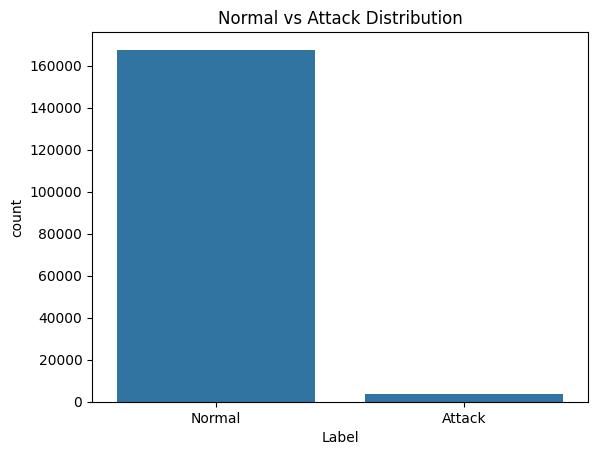

In [36]:
sns.countplot(x='Label', data=data)
plt.title('Normal vs Attack Distribution')

#### **Time (hours) when the attacks are more likely to occur**

<Axes: xlabel='hour', ylabel='Count'>

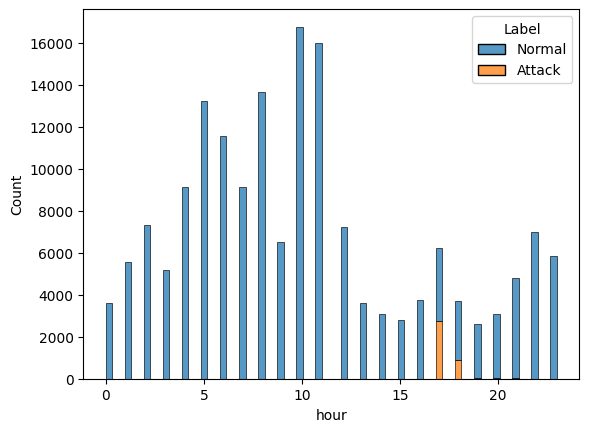

In [37]:
data['hour'] = pd.to_datetime(data['startDateTime']).dt.hour
sns.histplot(data=data, x='hour', hue='Label', multiple='stack')

#### **Risk Score for each Protocol**
    icmp_ip and tcp_ip have the highest risk score: 8.828% and 3.042% respectively

In [38]:
protocol_risk = data.groupby('protocolName')['Label'].value_counts(normalize=True).unstack()
protocol_risk['risk_score'] = protocol_risk['Attack'] * 100
protocol_risk.sort_values('risk_score', ascending=False, inplace=True)
protocol_risk

Label,Attack,Normal,risk_score
protocolName,,,
icmp_ip,0.088283,0.911717,8.828250
tcp_ip,0.030426,0.969574,3.042568
igmp,NaN,1.000000,NaN
ip,NaN,1.000000,NaN
udp_ip,NaN,1.000000,NaN


#### **Most suspicious destination ports**
    80 and 443 are the most suspicious destination ports with chance of attack 87.474% and 3.688% respectively 

In [70]:
suspicious_ports = data[data['Label']=='Attack']['destinationPort'].value_counts().head(10)
suspicious_ports = (suspicious_ports/suspicious_ports.sum())*100
suspicious_ports

destinationPort
80      87.474666
443      3.688691
4444     2.513174
0        2.229428
445      1.175517
143      1.134982
5555     0.932306
22       0.364816
25       0.243210
110      0.243210
Name: count, dtype: float64

#### **Probability Density of Source Payload Entropy for Normal and Attack**
    The distribution of entropy for normal traffic vs the attack traffic is different. The entropy of the attack traffic is more spread out than the normal traffic.

<Axes: xlabel='source_payload_entropy', ylabel='Density'>

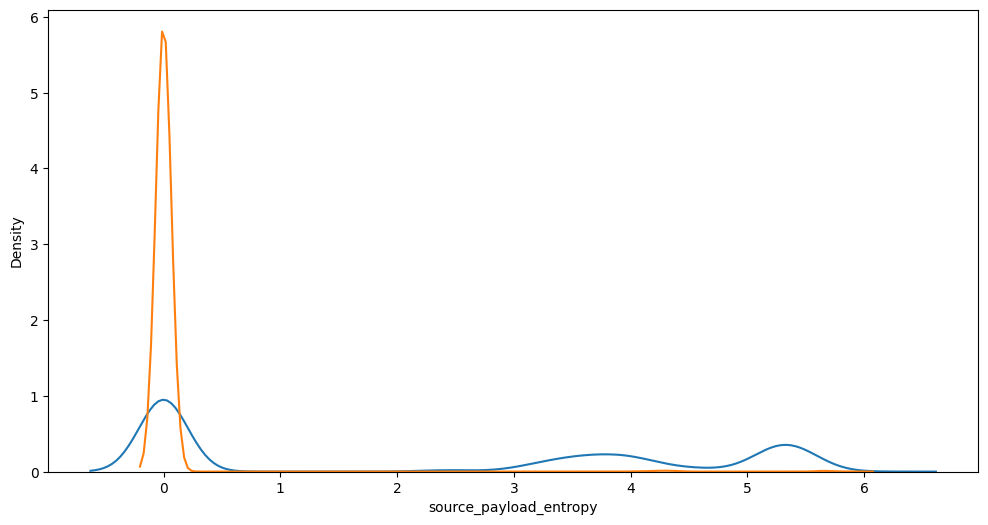

In [40]:
plt.figure(figsize=(12,6))
sns.kdeplot(data[data['Label']=='Normal']['source_payload_entropy'], label='Normal')
sns.kdeplot(data[data['Label']=='Attack']['source_payload_entropy'], label='Attack')

#### **The distribution of the length of the payload for normal and attack traffic**
    

In [41]:
data.groupby('Label')['source_payload_length'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Attack,3776.0,5.710805,81.541656,0.0,0.0,0.0,0.0,1368.0
Normal,167604.0,63.028585,138.758802,0.0,0.0,8.0,88.0,2732.0


#### **Distribution of the average number of bytes per for normal and attack traffic**

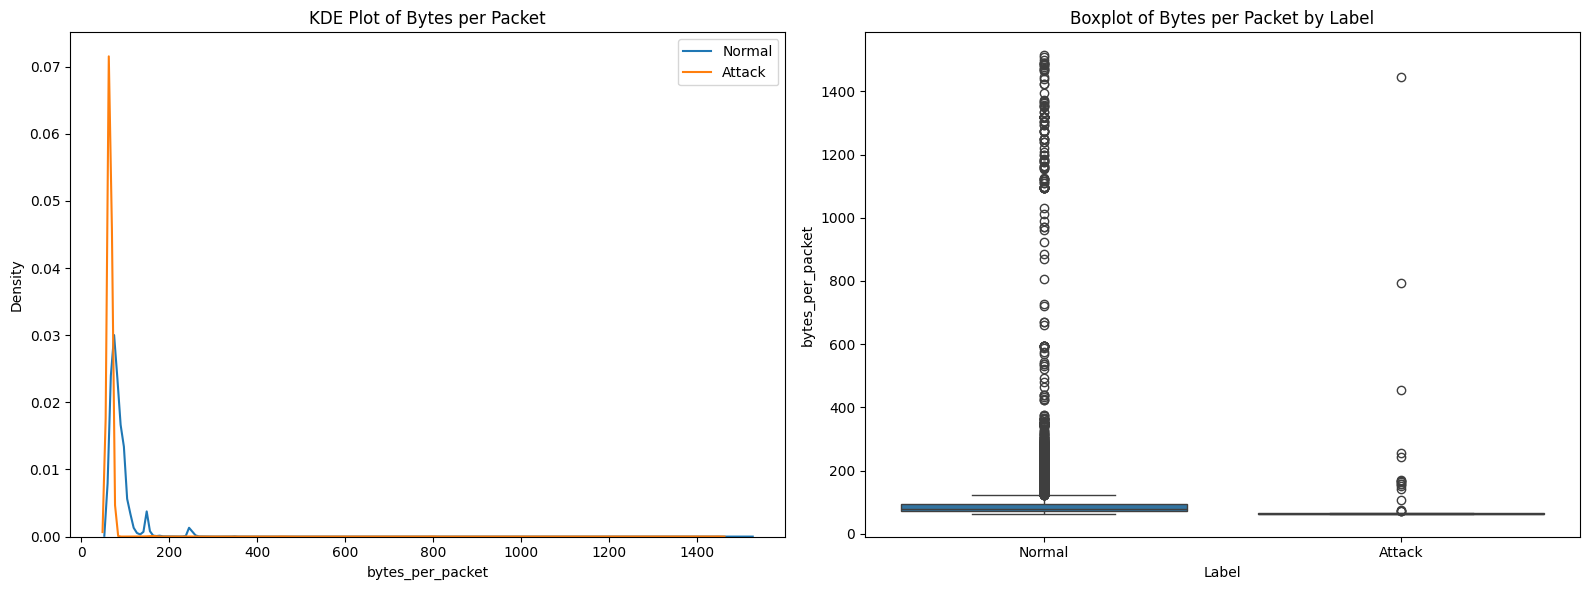

In [42]:
data['bytes_per_packet'] = data['totalSourceBytes'] / data['totalSourcePackets']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(data[data['Label'] == 'Normal']['bytes_per_packet'], label='Normal', ax=axes[0])
sns.kdeplot(data[data['Label'] == 'Attack']['bytes_per_packet'], label='Attack', ax=axes[0])
axes[0].set_title('KDE Plot of Bytes per Packet')
axes[0].legend()

sns.boxplot(x='Label', y='bytes_per_packet', data=data, ax=axes[1])
axes[1].set_title('Boxplot of Bytes per Packet by Label')

plt.tight_layout()
plt.show()

#### **Risk Score for each direction of the traffic**
    L2L is the most risky direction among all with a risk score of 16.69%

In [73]:
direction_risk = data.pivot_table(index='direction', columns='Label', values='source', aggfunc='count')
direction_risk['risk_score'] = (direction_risk['Attack'] / direction_risk['Normal'])*100
direction_risk

/var/folders/xq/ccxq36hs37q4jnq3zfl0gtsr0000gn/T/ipykernel_47677/679698998.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  direction_risk = data.pivot_table(index='direction', columns='Label', values='source', aggfunc='count')


Label,Attack,Normal,risk_score
direction,,,
L2L,3640,21804,16.694185
L2R,131,143996,0.090975
R2L,5,1593,0.313873
R2R,0,211,0.000000


#### **Cramer's V correlation matrix**
    Determines the strength of association between two categorical variables. It is based on the Chi-squared statistic and provides a value between 0 and 1
    
$$
V = \sqrt{\frac{\chi^2}{n \cdot (k - 1)}}
$$
where:
$$
\chi^2 = \sum \frac{(O - E)^2}{E}
$$
    ( O ): Observed frequency (actual count in the data).
    ( E ): Expected frequency (calculated assuming no association between variables).
    ( n ): Total number of observations.
    ( k ): Number of categories in the variable.

In [44]:
def cramers_v(feature):
    contingency = pd.crosstab(data[feature], data['Label'])
    chi2 = chi2_contingency(contingency)[0]
    n = contingency.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency.shape)-1)))

corr_matrix = pd.Series({
    'appName': cramers_v('appName'),
    'direction': cramers_v('direction'),
    'sourceTCPFlagsDescription': cramers_v('sourceTCPFlagsDescription'),
    'destinationTCPFlagsDescription': cramers_v('destinationTCPFlagsDescription'),
    'protocolName': cramers_v('protocolName'),
    'source_tcp_flags': cramers_v('source_tcp_flags'),
    'destination_tcp_flags': cramers_v('destination_tcp_flags')
})
corr_matrix

appName                           0.552821
direction                         0.344269
sourceTCPFlagsDescription         0.862863
destinationTCPFlagsDescription    0.745656
protocolName                      0.097178
source_tcp_flags                  0.862863
destination_tcp_flags             0.745656
dtype: float64

#### **Using ordinal encoding for Protocal and TCP Flag**

In [45]:
protocol_encoder = OrdinalEncoder().fit(data[['protocolName']])
tcp_flag_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(data[['source_tcp_flags']])
data['protocol_encoded'] = protocol_encoder.transform(data[['protocolName']])
tcp_features = tcp_flag_encoder.transform(data[['source_tcp_flags']])

#### **Creating a new feature Duration (in seconds) to replace StartDateTime and StopDateTime**

In [46]:
data['duration'] = (pd.to_datetime(data['stopDateTime']) - 
                 pd.to_datetime(data['startDateTime'])).dt.total_seconds()
data.drop(['startDateTime','stopDateTime'], axis=1, inplace=True)

### **Feature Engineering**

In [47]:
X = data.drop(columns=['Label'])
y = data['Label']

In [48]:
y = y.map({'Normal': 0, 'Attack': 1})
y

0         0
1         0
2         0
3         0
4         0
         ..
171375    0
171376    0
171377    0
171378    0
171379    0
Name: Label, Length: 171380, dtype: int64

#### **Converting all the object data types to cataegorical data types**

In [49]:
categorical_cols = [
    'generated', 'appName', 'direction', 
    'sourceTCPFlagsDescription', 'destinationTCPFlagsDescription',
    'source', 'protocolName', 'destination', 
    'source_tcp_flags', 'destination_tcp_flags'
]

for col in categorical_cols:
    data[col] = data[col].astype('category')

In [50]:
X = data.drop(columns=['Label'])
y = data['Label']

y = y.map({'Normal': 0, 'Attack': 1})

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171380 entries, 0 to 171379
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   generated                       171380 non-null  category
 1   appName                         171380 non-null  category
 2   totalSourceBytes                171380 non-null  int64   
 3   totalDestinationBytes           171380 non-null  int64   
 4   totalDestinationPackets         171380 non-null  int64   
 5   totalSourcePackets              171380 non-null  int64   
 6   direction                       171380 non-null  category
 7   sourceTCPFlagsDescription       171380 non-null  category
 8   destinationTCPFlagsDescription  171380 non-null  category
 9   source                          171380 non-null  category
 10  protocolName                    171380 non-null  category
 11  sourcePort                      171380 non-null  int64   
 12  de

*Using XGBClassifier to get the feature importance and selecting the important features out of them (with threshold score of >0.75)*

In [52]:
xgb = XGBClassifier(enable_categorical=True).fit(X, y)
importance_scores = xgb.feature_importances_
final_features = np.where(importance_scores > np.quantile(importance_scores, 0.75))[0]

In [53]:
final_features

array([ 1,  2,  6,  7,  9, 12, 27, 29])

In [54]:
X_data = X.iloc[:, final_features]
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171380 entries, 0 to 171379
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   appName                    171380 non-null  category
 1   totalSourceBytes           171380 non-null  int64   
 2   direction                  171380 non-null  category
 3   sourceTCPFlagsDescription  171380 non-null  category
 4   source                     171380 non-null  category
 5   destination                171380 non-null  category
 6   hour                       171380 non-null  int32   
 7   protocol_encoded           171380 non-null  float64 
dtypes: category(5), float64(1), int32(1), int64(1)
memory usage: 4.7 MB


#### **Splitting the data into train and test**

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)

### **Training on Model 1: XGBClassifier**
    Accuracy: 0.999
    Precision: 0.999
    Recall: 0.999
    F1 Score: 0.999
    AUC: 0.999

#### **Using grid search to find the best hyperparameters and then training the model using those hyperparameters**

In [56]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb = XGBClassifier(enable_categorical=True)
grid_search = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

#### **Heatmap of the confusion matrix**
    Out of 33492 normal labelled samples all are correctly classified as normal and out of 784 attack labelled samples 783 are correctly classified as attack and 1 is misclassified as normal

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33492
           1       1.00      1.00      1.00       784

    accuracy                           1.00     34276
   macro avg       1.00      1.00      1.00     34276
weighted avg       1.00      1.00      1.00     34276



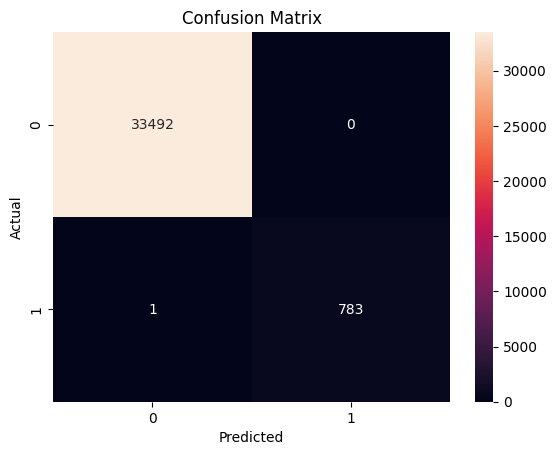

In [57]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **ROC Curve**
    The ROC curve is a graphical representation of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.

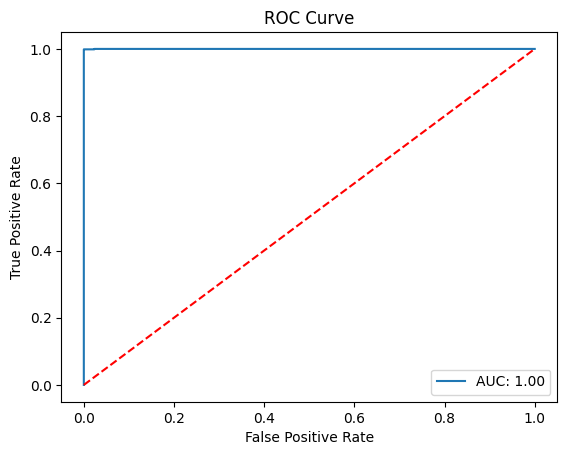

In [58]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC: {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### **Training on Model 2: Light GBM Classifier**
    Accuracy: 0.999
    Precision: 0.999
    Recall: 0.999
    F1 Score: 0.999
    AUC: 0.999

#### **Using grid search to find the best hyperparameters and then training the model using those hyperparameters**

In [66]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3]
}

lgbm = lgb.LGBMClassifier(verbose=-1)
grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-1), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200, 300, 500]})

In [67]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

#### **Heatmap of the confusion matrix**
    Out of 33492 normal labelled samples 33491 are correctly classified as normal and 1 was misclassified as attack and out of 784 attack labelled samples 782 are correctly classified as attack and 2 are misclassified as normal

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33492
           1       1.00      1.00      1.00       784

    accuracy                           1.00     34276
   macro avg       1.00      1.00      1.00     34276
weighted avg       1.00      1.00      1.00     34276



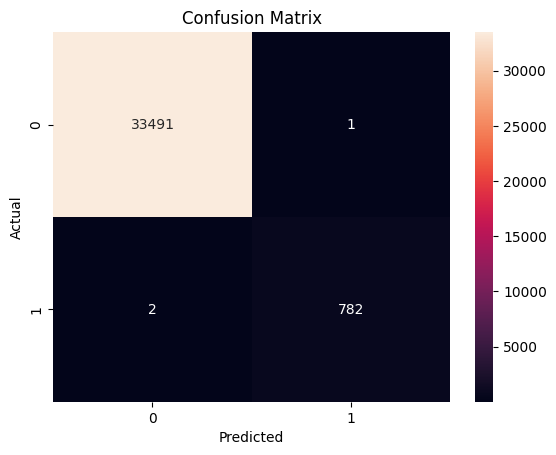

In [68]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **ROC Curve**
    The ROC curve is a graphical representation of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.

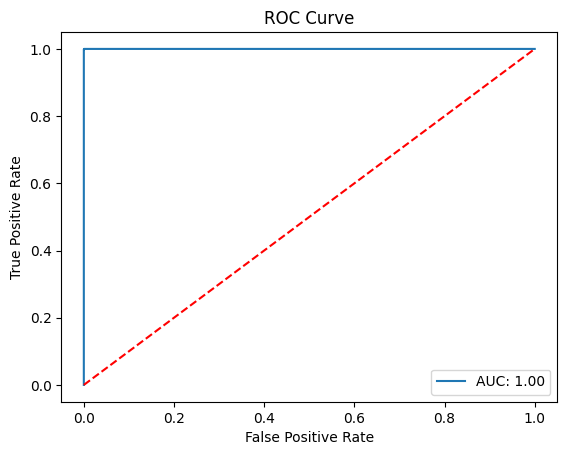

In [69]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC: {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()